In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1
!pip install tensorflow
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import sklearn
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)
print("sklearn version:", sklearn.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
seaborn version: 0.13.2
tensorflow version: 2.18.0
keras version: 3.8.0
sklearn version: 1.6.1


In [ ]:
# Import essential libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import zipfile

In [ ]:
# Load and unzip the dataset
from google.colab import drive
drive.mount('/content/drive')

!unzip -o "/content/drive/MyDrive/data.zip" -d "/content/drive/MyDrive/data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/data/data/Glass/file_96.png  
  inflating: /content/drive/MyDrive/data/data/Paper/file_560.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_620.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_676.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_177.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_749.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_460.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_127.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_438.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_132.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_98.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_427.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_351.png  
  inflating: /content/drive/MyDrive/data/data/Glass/file_74.png  
  inflating: /

In [ ]:
# Create a function to load the raw images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
dataset_path='/content/drive/MyDrive/data/data'
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 6100 images belonging to 7 classes.


In [ ]:
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1525 images belonging to 7 classes.


In [ ]:
# Get the images and their labels

images, labels = next(train_data)


In [ ]:
import numpy as np

all_images = []
all_labels = []

for i in range(len(train_data)):
    imgs, lbls = train_data[i]
    all_images.append(imgs)
    all_labels.append(lbls)

# Combine into single arrays
all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)


In [ ]:
class_indices = np.argmax(all_labels, axis=1)


In [ ]:
#print("Classes:", classes)
print("Number of images loaded:", len(all_images))
print("Data shape:", all_images.shape)
print("Labels shape:", all_labels.shape)
#label_encoder = LabelEncoder()
#labels_encoded = label_encoder.fit_transform(all_labels)
print("First 5 labels:", all_labels[:5])

Number of images loaded: 6100
Data shape: (6100, 128, 128, 3)
Labels shape: (6100, 7)
First 5 labels: [[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
class_indices = np.argmax(all_labels, axis=1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Get class indices (e.g., {'cat': 0, 'dog': 1})
class_indices = train_data.class_indices
class_labels = list(class_indices.keys())

# Get the list of filenames and convert to class names
labels_from_filenames = [path.split('/')[0] for path in train_data.filenames]


In [ ]:
label_counts = Counter(labels_from_filenames)


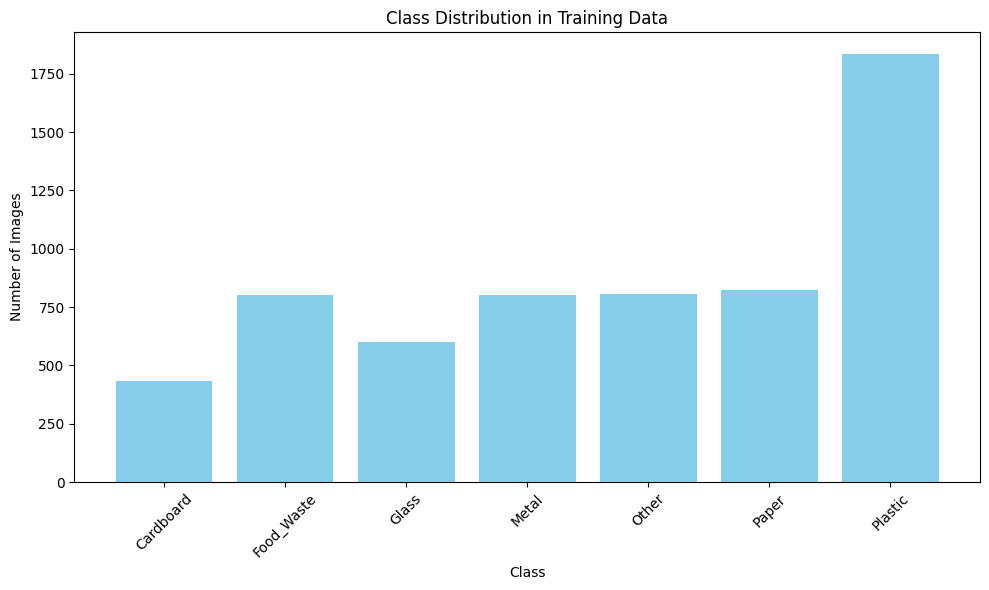

In [ ]:
# Visualise Data Distribution

plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


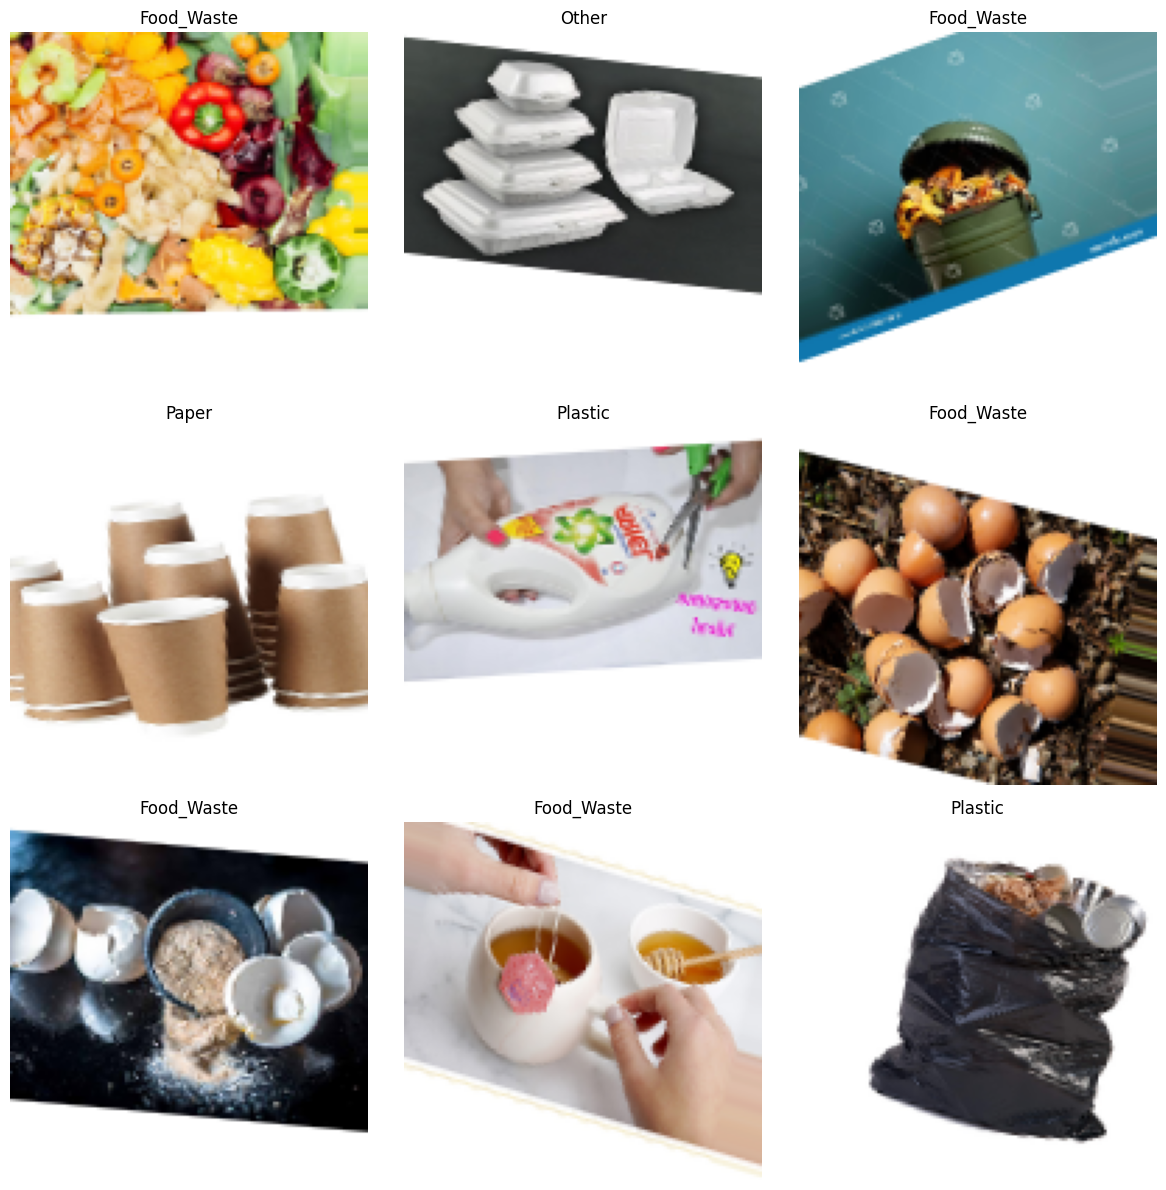

In [ ]:
# Visualise Sample Images (across different labels)

import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels
images, labels = next(train_data)

# Convert one-hot labels to class indices
class_indices = {v: k for k, v in train_data.class_indices.items()}
label_indices = np.argmax(labels, axis=1)

# Plotting
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 sample images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_indices[label_indices[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Find the smallest and largest image dimensions from the data set

import os
from PIL import Image

dataset_path = '/content/drive/MyDrive/data/data'

min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    min_width = min(min_width, width)
                    min_height = min(min_height, height)
                    max_width = max(max_width, width)
                    max_height = max(max_height, height)
            except:
                print(f"Could not open {img_path}")

print(f"📏 Smallest image dimensions: {min_width}x{min_height}")
print(f"📐 Largest image dimensions: {max_width}x{max_height}")


📏 Smallest image dimensions: 256x256
📐 Largest image dimensions: 256x256


In [ ]:
# Resize the image dimensions

import os
from PIL import Image

# Define paths
source_dir = '/content/drive/MyDrive/data/data'
target_dir = '/content/drive/MyDrive/data/resized_data'
target_size = (128, 128)

# Create target directory structure
os.makedirs(target_dir, exist_ok=True)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            rel_path = os.path.relpath(root, source_dir)
            save_dir = os.path.join(target_dir, rel_path)
            os.makedirs(save_dir, exist_ok=True)

            src_path = os.path.join(root, file)
            dst_path = os.path.join(save_dir, file)

            try:
                with Image.open(src_path) as img:
                    img = img.convert('RGB')  # ensure consistency
                    img = img.resize(target_size)
                    img.save(dst_path)
            except Exception as e:
                print(f"Error processing {src_path}: {e}")


In [ ]:
# Encode the labels suitably

import numpy as np

# Get one batch (images and labels)
images, labels = next(train_data)

# Mapping from class index to class name
idx_to_class = {v: k for k, v in train_data.class_indices.items()}

# Convert one-hot encoded labels to class indices
class_indices = np.argmax(labels, axis=1)

# Print the label mapping (class index → class name)
print("Label Mapping (Class Index → Class Name):")
for index, class_name in idx_to_class.items():
    print(f"{index}: {class_name}")

# Print encoded labels (class index for each image in the batch)
print("\nEncoded Labels for One Batch (Class Index):")
for i in range(len(class_indices)):
    print(f"Image {i + 1}: Class Index = {class_indices[i]}, Class Name = {idx_to_class[class_indices[i]]}")


Label Mapping (Class Index → Class Name):
0: Cardboard
1: Food_Waste
2: Glass
3: Metal
4: Other
5: Paper
6: Plastic

Encoded Labels for One Batch (Class Index):
Image 1: Class Index = 3, Class Name = Metal
Image 2: Class Index = 4, Class Name = Other
Image 3: Class Index = 3, Class Name = Metal
Image 4: Class Index = 6, Class Name = Plastic
Image 5: Class Index = 2, Class Name = Glass
Image 6: Class Index = 5, Class Name = Paper
Image 7: Class Index = 2, Class Name = Glass
Image 8: Class Index = 6, Class Name = Plastic
Image 9: Class Index = 3, Class Name = Metal
Image 10: Class Index = 6, Class Name = Plastic
Image 11: Class Index = 6, Class Name = Plastic
Image 12: Class Index = 6, Class Name = Plastic
Image 13: Class Index = 5, Class Name = Paper
Image 14: Class Index = 2, Class Name = Glass
Image 15: Class Index = 2, Class Name = Glass
Image 16: Class Index = 6, Class Name = Plastic
Image 17: Class Index = 0, Class Name = Cardboard
Image 18: Class Index = 6, Class Name = Plastic
Im

In [ ]:
# Assign specified parts of the dataset to train and validation sets

from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/drive/MyDrive/data/data'

# Create ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Training data (80% of the data)
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # This uses the 80% for training
)

# Validation data (20% of the data)
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # This uses the 20% for validation
)

# For the test set, we can either use a separate test folder or split the remaining 20% further.
# If you want to use a separate test folder, you can load it like this:



Found 6100 images belonging to 7 classes.
Found 1525 images belonging to 7 classes.


In [ ]:
# Build and compile the model

from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten the 3D output to 1D
    layers.Flatten(),

    # Fully connected Dense layer
    layers.Dense(128, activation='relu'),

    # Dropout to avoid overfitting
    layers.Dropout(0.5),

    # Output layer (one neuron per class, softmax for multi-class classification)
    layers.Dense(train_data.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For multi-class classification (one-hot encoding)
    metrics=['accuracy']
)

# Display model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training


from tensorflow.keras import callbacks

# Callbacks for early stopping and learning rate reduction
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

# Train the model
history = model.fit(
    train_data,                # Training data generator
    validation_data=val_data,  # Validation data generator
    epochs=30,                 # Number of epochs
    callbacks=[early_stop, reduce_lr]  # Callbacks to manage training
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.2806 - loss: 1.9133 - val_accuracy: 0.3311 - val_loss: 1.7359 - learning_rate: 0.0010
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.3394 - loss: 1.7435 - val_accuracy: 0.3475 - val_loss: 1.6864 - learning_rate: 0.0010
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.3640 - loss: 1.6473 - val_accuracy: 0.3639 - val_loss: 1.6043 - learning_rate: 0.0010
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.3803 - loss: 1.6058 - val_accuracy: 0.4033 - val_loss: 1.6003 - learning_rate: 0.0010
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.3878 - loss: 1.5785 - val_accuracy: 0.3915 - val_loss: 1.5613 - learning_rate: 0.0010
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.3981 - loss: 1.5486 - val_accuracy: 0.4007 - val_loss: 1.5793 - learning_rate: 0.0010
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.4181 - loss: 1.

Found 7625 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 110s 457ms/step - accuracy: 0.6025 - loss: 1.1852
Test Loss: 1.1511
Test Accuracy: 0.5862
239/239 ━━━━━━━━━━━━━━━━━━━━ 108s 452ms/step

Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.77      0.72      0.74       540
  Food_Waste       0.64      0.74      0.68      1000
       Glass       0.80      0.39      0.52       750
       Metal       0.62      0.51      0.56      1000
       Other       0.55      0.28      0.37      1010
       Paper       0.35      0.75      0.48      1030
     Plastic       0.72      0.65      0.68      2295

    accuracy                           0.59      7625
   macro avg       0.64      0.58      0.58      7625
weighted avg       0.64      0.59      0.59      7625



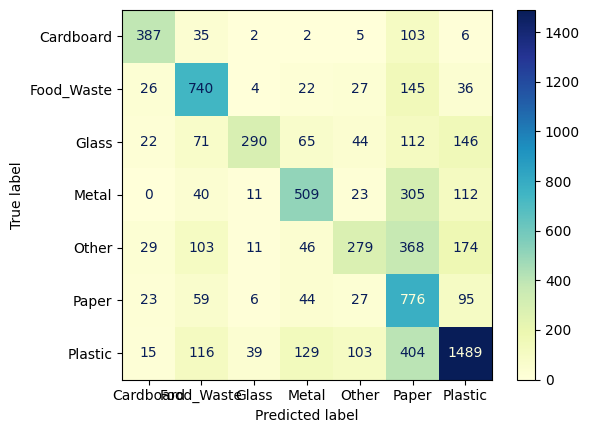

In [ ]:
# Define test data generator (without augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_data = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset=None,
    shuffle=False
    )

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict classes
y_pred_probs = model.predict(test_data)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true = test_data.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap='YlGnBu')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


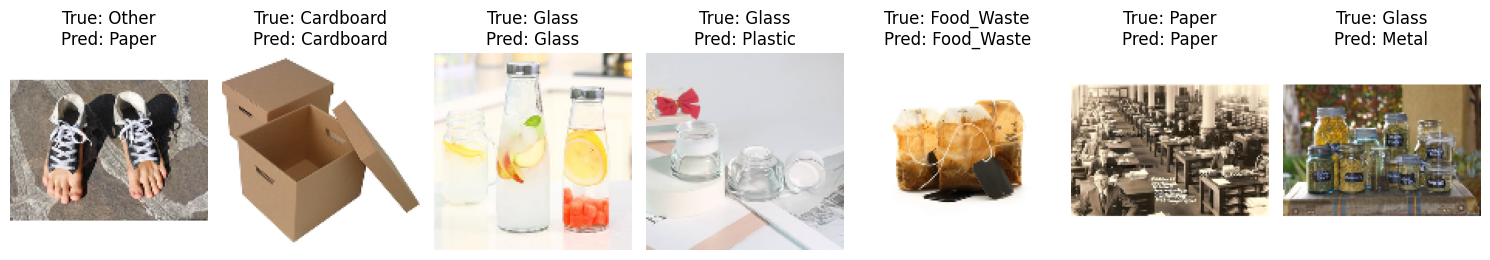

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.utils import load_img, img_to_array

# Get file paths and labels from the test_data generator
file_paths = test_data.filepaths
true_labels = test_data.classes
class_indices = test_data.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Randomly select N images
N = 7
random_indices = random.sample(range(len(file_paths)), N)
selected_paths = [file_paths[i] for i in random_indices]
selected_true_labels = [true_labels[i] for i in random_indices]

# Plot and predict
plt.figure(figsize=(15, 5))
for i, path in enumerate(selected_paths):
    img = load_img(path, target_size=(128, 128))  # Load and resize
    img_array = img_to_array(img) / 255.0         # Normalize
    img_expanded = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_expanded)
    pred_class = np.argmax(pred)

    plt.subplot(1, N, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {inv_class_indices[selected_true_labels[i]]}\nPred: {inv_class_indices[pred_class]}")

plt.tight_layout()
plt.show()


In [ ]:
# Define augmentation steps to augment images



In [ ]:
# Create a function to augment the images

In [ ]:
# Create the augmented training dataset



In [ ]:
# Train the model using augmented images

In [ ]:
## got an test accuracy of 58.62%  and the rest of the analysis and graphs are self explainatory as above
#trained the model using 3 Convolutional layers, 1 Dense layer using Softmax function and got above Confusion matrix and F1 scores